In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import sys
import skimage.measure
import pandas as pd
from PIL import Image
sys.path.append("../")
from optics import *
import utils
import optics

from denoising_unet import DenoisingUnet

## Helper Image Functions

In [2]:
def linear_to_srgb(img):
    return np.where(img <= 0.0031308, 12.92 * img, 1.055 * img ** (0.41666) - 0.055)

def srgb_to_linear(img):
    return np.where(img <= 0.04045, img / 12.92, ((img + 0.055) / 1.055) ** 2.4)

def image_loader(img_name):
    """ For optimizing over one image (testing)
    Usage: model_input, ground_truth = image_loader('input.png')
    :param img_name: str - path to single image file to load
    :return: Variable tensor of image in the format (1,C,H,W)
    """
    loader = transforms.Compose([transforms.CenterCrop(size=(256,256)),
                                 transforms.Resize(size=(512,512)),
                                 transforms.ToTensor()])

    image = Image.open(img_name)
    image = loader(image).float().cpu()
    image = torch.Tensor(srgb_to_linear(image))
    input_image = image.unsqueeze(0)  # specify a batch size of 1
    image = image.permute(1,2,0).cpu().detach().numpy()
    return input_image.cuda(), image

def wiener_filter(img, psf, K):

    img = torch.Tensor(img).cuda()
    psf = torch.Tensor(psf).cuda()

    img = img.permute(2,0,1)
    img = utils.stack_complex(img, torch.zeros(img.shape).cuda())
    img_fft = torch.fft(utils.ifftshift(img),2)


    otf = optics.psf2otf(psf, output_size=img.shape[1:3])
    
    otf = torch.stack((otf,otf,otf),0)

    conj_otf = utils.conj(otf)
    denominator = abs_complex(otf)
    denominator[:,:,:,0] += K


    otf_img = utils.mul_complex(conj_otf,img_fft)
    product = utils.div_complex(otf_img, denominator)
    filtered = utils.ifftshift(torch.ifft(product,2))
    
    filtered = torch.clamp(filtered, min=1e-5)
    filtered = filtered[:,:,:,0].cuda().squeeze(0)
    filtered = filtered.permute(1,2,0)

    return filtered.cpu().numpy()

## Loop through files to display non-Wiener filtered image and PSNR

Number of parameters: 262145
****************************************************************************************************
PSNR:  33.24499329207306
learn-doe/learn-doe_4_lr1e-08_focal_length0.0077


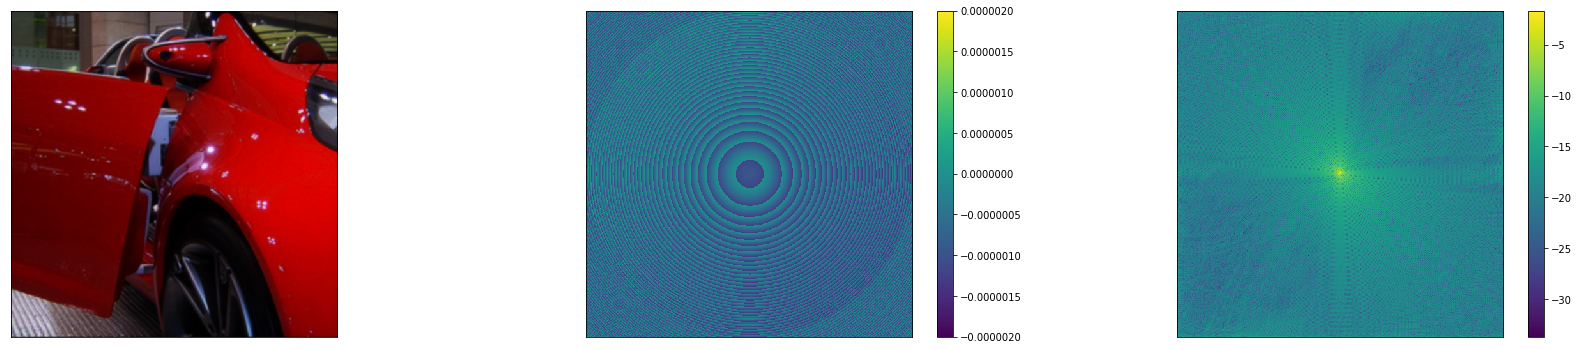

Number of parameters: 262145
****************************************************************************************************
PSNR:  37.11578579475153
learn-doe/learn-doe_6_lr1e-08_focal_length0.005


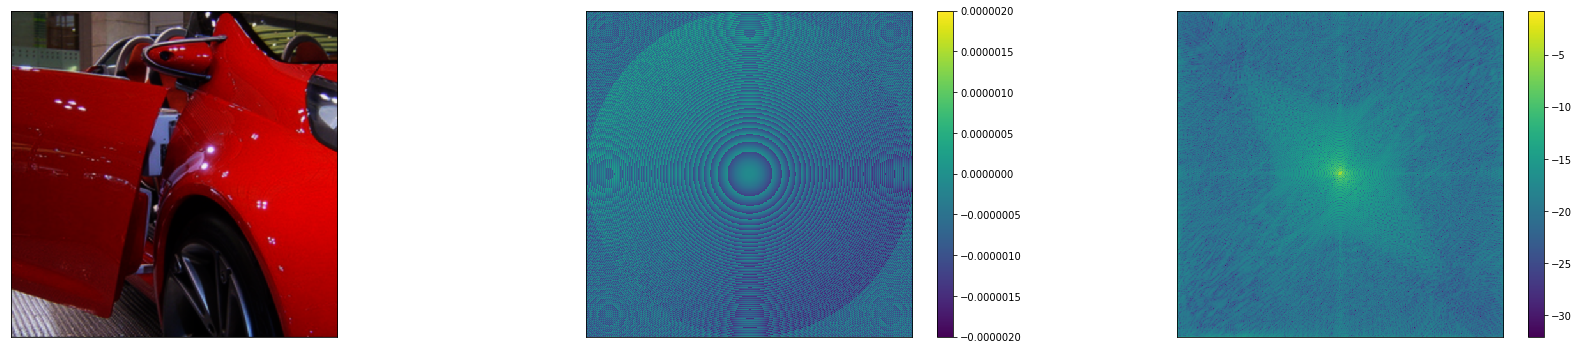

In [7]:
exp = ["learn-doe/learn-doe_4_lr1e-08_focal_length0.0077",
      "learn-doe/learn-doe_6_lr1e-08_focal_length0.005"]

rows_list = []
images = []
psfs = []
k = []


for i,name in enumerate(exp):
    
    for j in range(10,120,10):
        
        file = "../runs/"+ exp[i]+"/model_epoch_0_iter_{0}.pth".format(j)
        dict1 = {}
        with open(file, "rb") as fd:
                temp = torch.load(fd)
    
        if j == 100:
            
            model = DenoisingUnet(temp['hyps'])
            model.load_state_dict(temp['model_state_dict'])
            model.eval()

            img = "../data/2008_000027_val.jpg"
            input_img, ground_truth = image_loader(img)
            output_img = model(input_img)
            output_disp = output_img.squeeze(0)
            output_disp = output_disp.permute(1,2,0).cpu().detach().numpy()
  
            psnr = skimage.measure.compare_psnr(ground_truth, output_disp)
            print('PSNR: ', psnr)
            
            f = plt.figure(figsize=(30, 6))
            print(name)
            
            f.add_subplot(1, 3, 1)
           
            plt.imshow(output_disp)
            plt.xticks([], [])
            plt.yticks([], [])
            

            f.add_subplot(1, 3, 2)
            heightmap = temp['heightmap']
            plt.imshow(heightmap, vmin=-0.000002, vmax =0.000002)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.colorbar()
                             
            f.add_subplot(1, 3, 3)
            psf = temp['psf']
            plt.imshow(np.log(psf))
            plt.xticks([], [])
            plt.yticks([], [])
            plt.colorbar()
            plt.show()
            
            
            images.append(output_disp)
            psfs.append(psf)
            k.append(temp['K'])
            
                             

        loss = temp['loss'].cpu().detach().numpy()

        dict1 = {'fl':temp['focal_length'],
                 'psnr': temp['psnr'], 
                 'loss':loss,
                 'pixel_pitch':temp['pixel_pitch'],
                 'iter':temp['iter']}

        rows_list.append(dict1)
    
df = pd.DataFrame(rows_list)

## Apply wiener filtering

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
Damping factor:  tensor([0.0100])
PSNR:  37.68461417166448


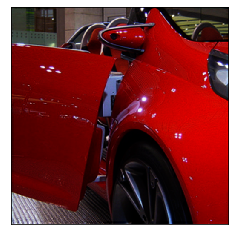

Damping factor:  tensor([0.0100])
PSNR:  43.17611880281927


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


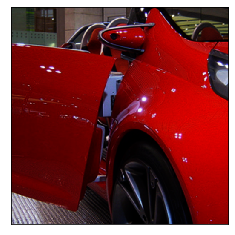

In [9]:
# Applying wiener filtering to image

img = "../data/2008_000027_val.jpg"
input_img, ground_truth = image_loader(img)
print(ground_truth.shape)
    
for i in range(len(psfs)):
    print("Damping factor: ",k[i])
    p = wiener_filter(images[i], psfs[i],k[i].cuda())
    psnr = skimage.measure.compare_psnr(ground_truth, p)
    print('PSNR: ', psnr)
    plt.figure()
    plt.imshow(p)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()

## Plot losses and PSNR

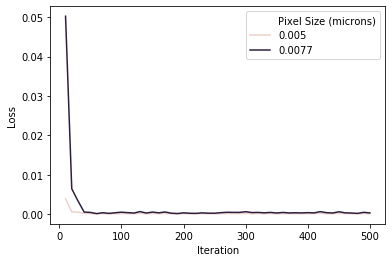

In [7]:
# use legend='full' so that seaborn will do numeric color mapping

g = sns.lineplot(x='iter',y='loss', hue="fl", data=df,legend="full") 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set(xlabel="Iteration", ylabel="Loss")

legend = g.legend()
legend.texts[0].set_text("Pixel Size (microns)")

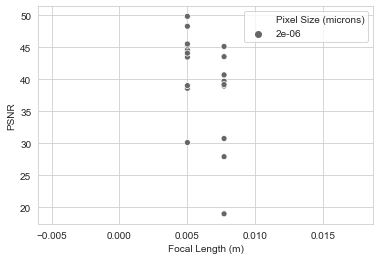

In [15]:
# use legend='full' so that seaborn will do numeric color mapping
sns.set_style("whitegrid")

g = sns.scatterplot(x='fl',y='psnr', hue="pixel_pitch", data=df,legend="full", palette="Accent_r") 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set(xlabel="Focal Length (m)", ylabel="PSNR")

legend = g.legend()
legend.texts[0].set_text("Pixel Size (microns)")

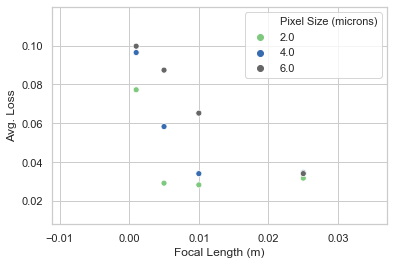

In [189]:
g = sns.scatterplot(x='fl',y='loss', hue="pixel_pitch", data=df,legend="full", palette="Accent")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set(xlabel="Focal Length (m)", ylabel="Avg. Loss")

legend = g.legend()
legend.texts[0].set_text("Pixel Size (microns)")

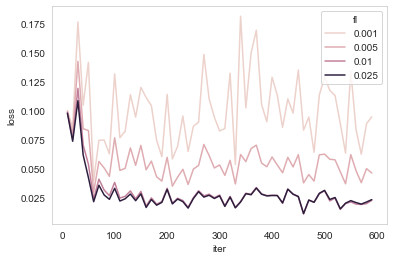

In [19]:
ax = sns.lineplot(x="iter", y="loss", hue="fl",data=df,legend="full")

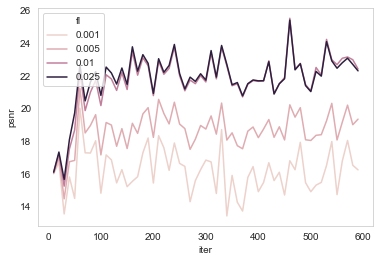

In [20]:
ax = sns.lineplot(x="iter", y="psnr", hue="fl",data=df,legend="full")